## User item collaborating filtering


Here we will be discussing an approach to implement collaborative filtering for movie recommendations.


In a movie rating scenario, we are given users and their movie preferences.
The preferences are ratings between 1-5 where 1 means "I didn't like this movie" and 5 "This movie is awesome". 

The goal is to predict ratings (and recommend) movies to users, based on their preferences, eg predict the rating for a given movie, for a given user.


The collaborative filtering approach makes the basic assumption that there are groups of users with similar preferences and that there are factors or categories of movies, so that similar users will tend to like similar movies.

If we have $U$ users and $M$ movies, 
we can formulate a representation of this problem with a matrix $A$ with dimensions $UxM$ where $A_{ij}$ will hold the rating of user $j$ for movie $j$  


This matrix looks like this:


<img src="images/recs.jpg"/>


We would like to predict the empty elements in the matrix and recommend movies to users accordingly.


### Latent factors and movie factorization

If we assume that there are $K << M$ unknown factors or movie categories, based on the above, we can assume that each movie has certan weights for each of these factors and similarily, each user has weight preferences for these factors as well. These factors can be thought as a combination of known or unknown properties of the movies, eg genre, director, actors etc.  


So, we can think movie factors as a matrix $W_m$ with dimensions $KxM$ and the users as a matrix $W_u$ with dimensions $UxK$

Then, we can say that the ratings are a linear combination of user preferences and movie categories, so that 
$$ A \approx W_u * W_m$$

This implies a linear relationship (dot product) between user preferences and movie factors, and since K is typically much smaller than M, this is essentially low rank matrix factorisation.


We formulate the matrix factorisation problem as an optimisation problem,
were we seek to minimise the distance between known ratings and predicted ratings in the factorisation problem.

$$  argmin_{W_u, W_m} L = \sum_{i,j} (R - W_u * W_m)^2 $$ 


we can also enforce regularization to prevent weights on $W_m, W_u$ to grow too large:


$$  argmin_{W_u, W_m} L = \sum_{i,j} (R - W_u * W_m)^2  + \lambda_1 ||W_m||_2 + \lambda_2 || W_u ||_2 $$ 



<img src="images/factorized_ratings.jpg"/>


Let's see how we can implement this with pytorch





In [2]:
import pandas as pd
import numpy as np
import implicit
import matplotlib.pyplot as plt
import torch
from torch.optim import SGD, Adam, LBFGS

In [100]:
C = torch.randint( low=1, high=5, size = (200,300), dtype=torch.float32)

K = 100

torch.Size([200, 300])
epoch 0, loss=450306.3125
epoch 50, loss=46860.91796875
epoch 100, loss=21616.853515625
epoch 150, loss=14814.2421875
epoch 200, loss=13273.451171875
epoch 250, loss=12952.697265625
epoch 300, loss=12823.48046875
epoch 350, loss=12764.9609375
epoch 400, loss=12734.455078125
epoch 450, loss=12716.2880859375
epoch 500, loss=12704.46875
epoch 550, loss=12696.671875
epoch 600, loss=12691.6298828125
epoch 650, loss=12688.34765625
epoch 700, loss=12686.08203125
epoch 750, loss=12684.380859375
epoch 800, loss=12683.00390625
epoch 850, loss=12681.8447265625
epoch 900, loss=12680.857421875
epoch 950, loss=12680.029296875
epoch 1000, loss=12679.3466796875
epoch 1050, loss=12678.798828125
epoch 1100, loss=12678.369140625
epoch 1150, loss=12678.03515625
epoch 1200, loss=12677.77734375
epoch 1250, loss=12677.57421875
epoch 1300, loss=12677.4111328125
epoch 1350, loss=12677.271484375
epoch 1400, loss=12677.146484375
optimisation converged: loss=12677.119140625


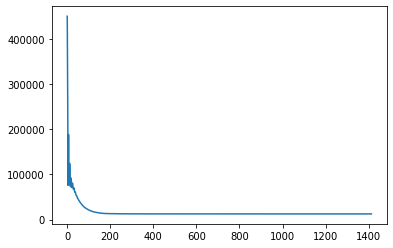

In [109]:
print(C.shape)
U, M = C.shape

## Start with random weights of zero mean and 0.01 variance
W1 = torch.randn( (U,K))*0.01
W2 = torch.randn( (K,M))*0.01

W1.requires_grad = True
W2.requires_grad = True
epochs = 1501 
optimizer = Adam( params = [W1,W2], lr=0.05)
items = [] 
prev_loss = 1e10

for epoch in range(epochs):
    optimizer.zero_grad()
    b = W1.matmul(W2) 
    loss = ((C-b)**2).sum()
    if epoch % 50 == 0:
        print( f"epoch {epoch}, loss={loss.item()}")

    loss.backward()
    optimizer.step()
    l = loss.item()
    
    items.append(l)
    if np.abs(l-prev_loss)<1e-5:
        print(f"optimisation converged: loss={l}")
        break
    
    prev_loss = l

plt.plot( range(epoch+1), items)
plt.show()

Q: How do we apply this in a ratings matrix where we are missing values (ratings)?

A: The solution is to use only the available ratings for the training/loss function minimisation step.



## MovieLens data set and matrix factorisation


In [9]:
ratings = pd.read_csv("./data/ml-latest-small/ratings.csv")
movies = pd.read_csv("./data/ml-latest-small/movies.csv")

In [10]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [11]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
ratings.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [13]:
M = movies.shape[0]
U = ratings.userId.unique().shape[0]
U, M


(610, 9742)

In [14]:
id_to_movie = movies[["movieId"]].to_dict()['movieId']
movie_to_idx = { m:i   for i,m in id_to_movie.items() }


## Build the matrix A of user movie ratings

In [15]:
A = np.zeros((U,M), dtype=np.float32)
A.dtype

#from scipy.sparse import csc_matrix
#A = csc_matrix((M, U), dtype=np.float32) #.toarray()

dtype('float32')

In [16]:
for idx, rec in ratings.iterrows():
    
    uid = rec.userId.astype(np.int32)-1
    mid =  movie_to_idx[rec.movieId.astype(np.int32)]
    A[uid][mid] = rec.rating.astype(np.float32) 
    

In [17]:
np.save(  "./data/ml-latest-small/A.npy", A)

In [18]:
A=  np.load( "./data/ml-latest-small/A.npy" )

### Convert rating matrix to torch object

In [19]:
R = torch.from_numpy(A)
U, M = R.shape
U, M, R.dtype

(610, 9742, torch.float32)

In [20]:
## Number of latent factors

In [21]:
K = 100

In [43]:



## Start with random weights of zero mean and 0.01 variance
W1 = torch.randn( (U,K))*0.01
W2 = torch.randn( (K,M))*0.01

W1.requires_grad = True
W2.requires_grad = True

optimizer = Adam(params = [W1,W2],lr=0.1)#, lr = 0.001 )
#optimizer = SGD(params = [W1,W2], lr=0.1)

In [44]:
M, U, K, R.shape, W1.shape, W2.shape


(9742,
 610,
 100,
 torch.Size([610, 9742]),
 torch.Size([610, 100]),
 torch.Size([100, 9742]))

In [45]:
## use these parameters to regularize the learned weights
l1 = 0.01
l2 = 0.01

epochs = 1001
epoch_plot = []
for epoch in range(epochs):
    
    optimizer.zero_grad()
    b = W1.matmul(W2) # #b = 4*torch.sigmoid(W1.matmul(W2))+1
   
    
    #b[b<1] = 1
    #b[b>5] = 5
    
    loss = ((R[R!=0] - b[R!=0])**2).sum()  + l1*(W1**2).sum() + l2*(W2**2).sum()

    loss.backward()
    
    optimizer.step()
    
    l = loss.item()
    
    epoch_plot.append( l )
    if epoch % 20 == 0 :
        print( f"epoch {epoch}, loss={l}")

epoch 0, loss=1345941.5
epoch 20, loss=66754.984375
epoch 40, loss=11103.546875
epoch 60, loss=3759.48486328125
epoch 80, loss=1961.4681396484375
epoch 100, loss=1349.326171875
epoch 120, loss=1040.6688232421875
epoch 140, loss=861.18994140625
epoch 160, loss=746.2448120117188
epoch 180, loss=667.667724609375
epoch 200, loss=611.0267944335938
epoch 220, loss=568.57421875
epoch 240, loss=535.2847900390625
epoch 260, loss=508.5990905761719
epoch 280, loss=486.48681640625
epoch 300, loss=467.7751770019531
epoch 320, loss=452.0036315917969
epoch 340, loss=437.97113037109375
epoch 360, loss=425.3898010253906
epoch 380, loss=414.31134033203125
epoch 400, loss=403.6337585449219
epoch 420, loss=394.267822265625
epoch 440, loss=385.9349670410156
epoch 460, loss=378.1769104003906
epoch 480, loss=370.8154296875
epoch 500, loss=363.63336181640625
epoch 520, loss=357.6796569824219
epoch 540, loss=351.03424072265625
epoch 560, loss=345.88446044921875
epoch 580, loss=342.833251953125
epoch 600, loss=

### plot the loss function

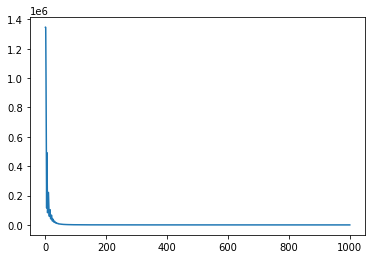

In [46]:
plt.plot( range(epochs), epoch_plot)

In [47]:
W1.shape

torch.Size([610, 100])

### Generate recommendations for a given user

#### Movies rated by this user

In [48]:
usr = 100

user1 = W1[usr,:]

m_ids = ratings[ratings.userId ==usr+1][["movieId", "rating"]].sort_values(by="rating", ascending=False).head(15)
movies.merge( m_ids, on=["movieId"]).sort_values(by="rating", ascending=False)

,movieId,title,genres,rating
1,1093,"Doors, The (1991)",Drama,5.0
2,1719,"Sweet Hereafter, The (1997)",Drama,5.0
3,2318,Happiness (1998),Comedy|Drama,5.0
4,2395,Rushmore (1998),Comedy|Drama,5.0
5,2599,Election (1999),Comedy,5.0
6,2712,Eyes Wide Shut (1999),Drama|Mystery|Thriller,5.0
11,2959,Fight Club (1999),Action|Crime|Drama|Thriller,5.0
12,2997,Being John Malkovich (1999),Comedy|Drama|Fantasy,5.0
14,3174,Man on the Moon (1999),Comedy|Drama,5.0
0,223,Clerks (1994),Comedy,4.0


#### Generate recommendations, rank by estimated rating and filter out already rated movies and movies with estimated rating < 3


In [49]:
ret = user1.matmul(W2)
r, idx = ret.topk(100)
vals = idx.numpy()
vals = [id_to_movie[val] for val in vals]
recs = movies[movies.movieId.isin(vals)].copy()
recs["ratings"] = r.detach().numpy()
recs = recs[recs.ratings>=3]
recs[~recs.movieId.isin(m_ids.movieId.values)].head(n=10)

,movieId,title,genres,ratings
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,5.673756
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,5.402719
315,357,Four Weddings and a Funeral (1994),Comedy|Romance,5.397323
461,527,Schindler's List (1993),Drama|War,5.179787
474,541,Blade Runner (1982),Action|Sci-Fi|Thriller,5.115816
602,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,5.107656
659,858,"Godfather, The (1972)",Crime|Drama,5.044997
681,899,Singin' in the Rain (1952),Comedy|Musical|Romance,5.041433
686,904,Rear Window (1954),Mystery|Thriller,5.036303
690,908,North by Northwest (1959),Action|Adventure|Mystery|Romance|Thriller,5.036211


#### Bonus: Movie Similarity 


If we multiply a movie specific row with the entire matrix, we can think the resulting vector as similarity weights of this movie with all other movies. 

In [55]:
test_movie_id = 1196
movies[movies.movieId==test_movie_id][["title"]]

,title
898,Star Wars: Episode V - The Empire Strikes Back...


In [56]:
m = W2[:, movie_to_idx[test_movie_id]]
vals, indexes = torch.topk( m.matmul(W2), k=10)
similar_ids = [ id_to_movie[v] for v in indexes.numpy() if v!=test_movie_id]

movies[movies.movieId.isin(similar_ids)]

,movieId,title,genres
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
507,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi
706,924,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi
898,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
899,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
900,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
911,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
990,1291,Indiana Jones and the Last Crusade (1989),Action|Adventure
2372,3147,"Green Mile, The (1999)",Crime|Drama


# Alternating Least Squares algorithm

In [90]:
import implicit
from scipy import sparse



In [ ]:
model = implicit.als.AlternatingLeastSquares(factors=100, iterations=10)


In [91]:
B=sparse.csr_matrix(A)

In [92]:
model.fit(B, show_progress=True)

In [93]:
user_items = B.T.tocsr()

In [94]:
ratings.groupby(by="userId").count().reset_index()

,userId,movieId,rating,timestamp
0,1,232,232,232
1,2,29,29,29
2,3,39,39,39
3,4,216,216,216
4,5,44,44,44
...,...,...,...,...
605,606,1115,1115,1115
606,607,187,187,187
607,608,831,831,831
608,609,37,37,37


In [95]:
userId = 99
ids = ratings[(ratings.userId==userId+1) & (ratings.rating>=4)].movieId.values

movies[movies.movieId.isin(ids)].head()


,movieId,title,genres
10,11,"American President, The (1995)",Comedy|Drama|Romance
15,16,Casino (1995),Crime|Drama
16,17,Sense and Sensibility (1995),Drama|Romance
27,28,Persuasion (1995),Drama|Romance
55,62,Mr. Holland's Opus (1995),Drama


In [96]:
recommendations = model.recommend(userId, user_items)
recommendations

[(455, 0.7284911),
 (239, 0.66431355),
 (268, 0.6642281),
 (313, 0.66291064),
 (116, 0.6429459),
 (150, 0.632777),
 (265, 0.6039506),
 (149, 0.60115194),
 (31, 0.58684206),
 (70, 0.5799792)]

In [97]:
recs = [r for r,_ in recommendations]
movies[movies.index.isin(recs)]

,movieId,title,genres
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
70,78,"Crossing Guard, The (1995)",Action|Crime|Drama|Thriller
116,141,"Birdcage, The (1996)",Comedy
149,177,Lord of Illusions (1995),Horror
150,178,Love & Human Remains (1993),Comedy|Drama
239,277,Miracle on 34th Street (1994),Drama
265,305,Ready to Wear (Pret-A-Porter) (1994),Comedy
268,308,Three Colors: White (Trzy kolory: Bialy) (1994),Comedy|Drama
313,355,"Flintstones, The (1994)",Children|Comedy|Fantasy
455,520,Robin Hood: Men in Tights (1993),Comedy


In [98]:
test_movie_id = 1196
# find related items
related = model.similar_users( test_movie_id )
rel = [ r for r,_ in related]
sorted(rel)
related

[(1196, 1.0000002),
 (2774, 0.7209943),
 (2533, 0.7193007),
 (3337, 0.7131566),
 (3055, 0.6933945),
 (5084, 0.6596235),
 (1844, 0.6570356),
 (4709, 0.6324284),
 (3429, 0.6322276),
 (3297, 0.632178)]

In [99]:
movies[movies.index.isin(rel)]

,movieId,title,genres
1196,1593,Picture Perfect (1997),Comedy|Romance
1844,2453,"Boy Who Could Fly, The (1986)",Drama|Fantasy
2533,3393,Date with an Angel (1987),Comedy|Fantasy|Romance
2774,3712,Soapdish (1991),Comedy
3055,4091,Can't Buy Me Love (1987),Comedy|Romance
3297,4462,18 Again! (1988),Comedy|Fantasy
3337,4520,License to Drive (1988),Comedy
3429,4672,"Tall Guy, The (1989)",Comedy|Romance
4709,7026,Summer School (1987),Comedy
5084,8011,"Weather Underground, The (2002)",Documentary
